In [1]:
import os
from argparse import ArgumentParser

import numpy as np
import matplotlib.pyplot as plt
import wandb
import torch
from denoising_diffusion_pytorch import Unet, GaussianDiffusion, Trainer
from encoder_decoders.vq_vae_encdec import VQVAEEncoder, VQVAEDecoder
from vector_quantization import VectorQuantize
from utils import load_yaml_param_settings, get_root_dir, freeze
from einops import rearrange

from stage2 import load_pretrained_encoder_decoder_vq

In [2]:
def load_args():
    parser = ArgumentParser()
    parser.add_argument('--config', type=str, help="Path to the config data  file.",
                        default=get_root_dir().joinpath('configs', 'config.yaml'))
    return parser.parse_args([])

In [3]:
# Load the trained LDM

# load config
args = load_args()
config = load_yaml_param_settings(args.config)

# load the pretrained encoder, decoder, and vq
encoder, decoder, vq_model = load_pretrained_encoder_decoder_vq(config, 'saved_models', freeze_models=True)
encoder_cond, decoder_cond, vq_model_cond = load_pretrained_encoder_decoder_vq(config, 'saved_models', freeze_models=True, load_cond_models=True)
encoder, decoder, vq_model = encoder.cuda(), decoder.cuda(), vq_model.cuda()
encoder_cond, decoder_cond, vq_model_cond = encoder_cond.cuda(), decoder_cond.cuda(), vq_model_cond.cuda()

# model
net_cond = Unet(
        in_channels=config['VQ-VAE']['codebook_dim'],
        dim=64,
        dim_mults=(1, 2, 4, 8),
        self_condition=config['diffusion']['unet']['self_condition'],
        conditional_net=True
    ).cuda()
net = Unet(
    in_channels=config['VQ-VAE']['codebook_dim'],
    dim=64,
    dim_mults=(1, 2, 4, 8),
    self_condition=config['diffusion']['unet']['self_condition'],
    net_cond=net_cond,
).cuda()

diffusion = GaussianDiffusion(
    net,
    in_size=encoder.H_prime[0].item(),  # width or height of z
    timesteps=1000,  # number of steps
    sampling_timesteps=1000,
    # number of sampling timesteps (using ddim for faster inference [see citation for ddim paper])
    loss_type='l1',  # L1 or L2
    auto_normalize=False,
).cuda()

# train
wandb.init(project='GeoDiffusion-stage2',config=config)
trainer = Trainer(
    diffusion,
    config,
    encoder,
    decoder,
    vq_model,
    encoder_cond,
    vq_model_cond,
    train_batch_size=config['dataset']['batch_sizes']['stage2'],
    train_lr=8e-5,
    train_num_steps=700000,  # total training steps
    gradient_accumulate_every=2,  # gradient accumulation steps
    ema_decay=0.995,  # exponential moving average decay
    amp=False,  # turn on mixed precision
    fp16=False,
    save_and_sample_every=1000, # default: 1000,
    num_samples=9,
    augment_horizontal_flip=False
)

wandb: Currently logged in as: daesoolee. Use `wandb login --relogin` to force relogin


Data loading... 0%
Data loading... 50%
self.X_train.shape: (140, 4, 128, 128)
self.X_test.shape: (60, 4, 128, 128)


In [4]:
# load the pretrained LDM
trainer.load(milestone=28)

loading from version 1.2.2


In [6]:
from utils import quantize

# cond
num_samples = 9
X_cond = []
for _ in range(num_samples):
    i = np.random.choice(len(trainer.ds))
    x, x_cond = trainer.ds[i]  # (c h w)
    X_cond.append(x_cond.numpy())
X_cond = torch.from_numpy(np.array(X_cond))  # (b c h w); b == num_samples
z_cond = trainer.pretrained_encoder_cond(X_cond.to(trainer.accelerator.device))  # (b c h' w')
z_q_cond, _, _, _ = quantize(z_cond, trainer.pretrained_vq_cond, return_z_q_before_proj_out=True)
z_q_cond = z_q_cond / z_q_cond.abs().max(dim=1, keepdim=True).values

In [14]:
# sample z
trainer.ema.ema_model.eval()
z_gen = trainer.ema.ema_model.sample(z_q_cond, batch_size=num_samples)

print('z_gen.shape:', z_gen.shape)

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

z_gen.shape: torch.Size([9, 4, 32, 32])


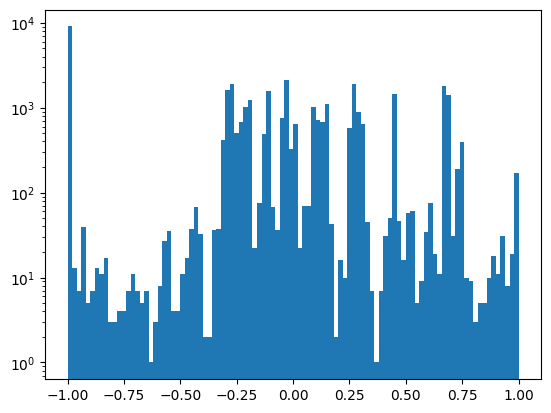

In [15]:
plt.hist(z_gen.cpu().detach().numpy().flatten(), bins=100, log=True)
plt.show()

In [16]:
# # VQ(z_gen)
# h, w = z_gen.shape[2], z_gen.shape[3]
# z_gen = rearrange(z_gen, 'b d h w -> b (h w) d')
# z_gen, _ = trainer.pretrained_vq._codebook(z_gen)
# z_gen = rearrange(z_gen, 'b (h w) d -> b d h w', h=h, w=w)

# decode
z_gen = rearrange(z_gen, 'b d h w -> b h w d')
z_gen = trainer.pretrained_vq.project_out(z_gen)
z_gen = rearrange(z_gen, 'b h w d -> b d h w')
print('z_gen.shape:', z_gen.shape)

x_gen = trainer.pretrained_decoder(z_gen)  # (b c h w)
x_gen = x_gen.cpu().detach()
x_gen = x_gen.argmax(dim=1)[:,None,:,:].float()
print('x_gen.shape:', x_gen.shape)

z_gen.shape: torch.Size([9, 64, 32, 32])
x_gen.shape: torch.Size([9, 1, 128, 128])


In [17]:
# x_gen

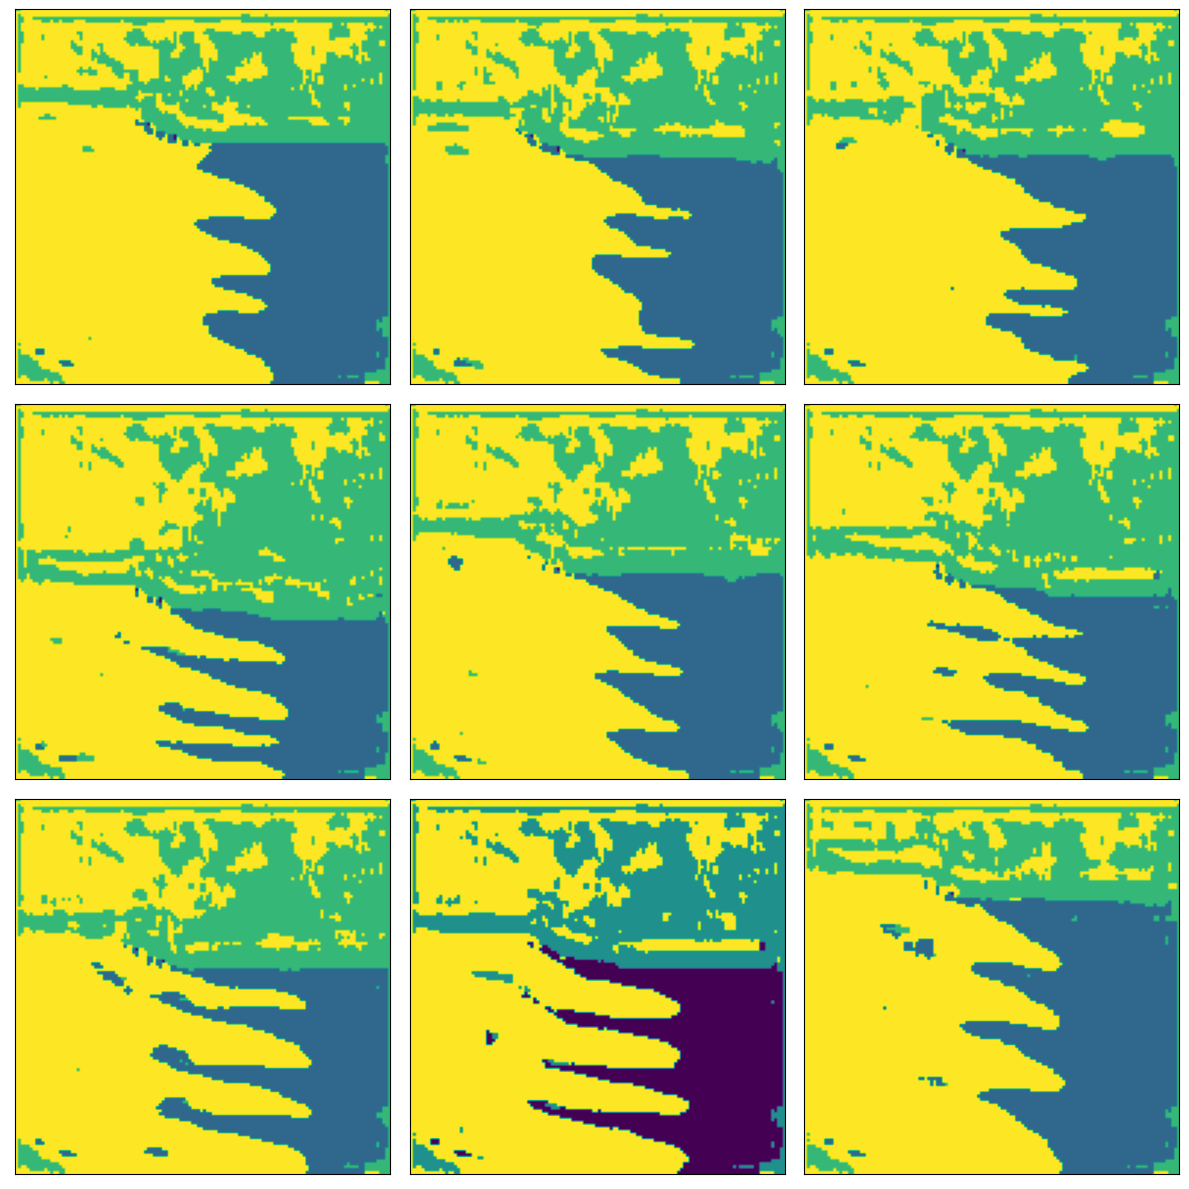

In [18]:
# plot
n_samples = x_gen.shape[0]
n_rows = int(np.ceil(np.sqrt(n_samples)))
fig, axes = plt.subplots(n_rows, n_rows, figsize=(12, 12))
axes = axes.flatten()

data = x_gen.numpy()  # (b 1 h w)
data = np.flip(data, axis=2)  # (b 1 h w)
data = data.squeeze()  # (b h w)
for i in range(n_samples):
    d = data[i]  # (h w)
    axes[i].imshow(d)
    axes[i].set_xticks([])
    axes[i].set_yticks([])
plt.tight_layout()
plt.show()

In [ ]:
# sample many and save

# sample z
trainer.ema.ema_model.eval()
z_gen = trainer.ema.ema_model.sample(batch_size=200)

# sample x_gen
z_gen = rearrange(z_gen, 'b d h w -> b h w d')
z_gen = trainer.pretrained_vq.project_out(z_gen)
z_gen = rearrange(z_gen, 'b h w d -> b d h w')
print('z_gen.shape:', z_gen.shape)

x_gen = trainer.pretrained_decoder(z_gen)  # (b c h w)
x_gen = x_gen.cpu().detach()
x_gen = x_gen.argmax(dim=1)[:,None,:,:].float()
print('x_gen.shape:', x_gen.shape)


In [20]:
import pandas as pd

# save
with open('X_gen_20230307.npy', 'wb') as f:
    np.save(f, x_gen[:, 0, : ,:])